# 02 — Análise Exploratória de Dados (EDA)



## Objetivo

Esta análise exploratória tem caráter **metodológico e decisório**:
cada achado é diretamente vinculado a uma escolha experimental.

| Achado do EDA | Decisão Metodológica |
|---|---|
| Desbalanceamento entre classes | → Hipótese 3: Class Weighting |
| Tamanho moderado do dataset | → Transfer Learning (não treinar do zero) |
| Alta variabilidade de dimensões | → Resize + CenterCrop padronizados |
| Artefatos nas bordas | → CenterCrop (0.9 do resize) |
| Padrões espaciais/texturais | → CNN como arquitetura base |
| Diferenças visuais sutis em alguns casos | → Testar DenseNet121 (H1) |
| Distribuição ampla de intensidades | → Normalização ImageNet |


## 1. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image
from collections import Counter

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))

figures_dir = os.path.join(PROJECT_ROOT, "outputs", "figures")
os.makedirs(figures_dir, exist_ok=True)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"

print("Project root:", PROJECT_ROOT)
print("Figures dir: ", figures_dir)

Project root: c:\projects\xray-project
Figures dir:  c:\projects\xray-project\outputs\figures


## 2. Carregamento dos Metadados

In [2]:
metadata_dir = os.path.join(PROJECT_ROOT, "data", "metadata")

df       = pd.read_csv(os.path.join(metadata_dir, "train_metadata.csv"))
train_df = pd.read_csv(os.path.join(metadata_dir, "train_split.csv"))
val_df   = pd.read_csv(os.path.join(metadata_dir, "val_split.csv"))

print(f"Dataset completo: {len(df)} imagens")
print(f"Split treino:     {len(train_df)} imagens")
print(f"Split validação:  {len(val_df)} imagens")
print()
print(df["label"].value_counts().rename({0: "Normal", 1: "Pneumonia"}))

Dataset completo: 5232 imagens
Split treino:     4093 imagens
Split validação:  1139 imagens

label
Pneumonia    3883
Normal       1349
Name: count, dtype: int64


## 3. Distribuição de Classes — Motivação para o Class Weighting

**Achado que fundamenta a Hipótese 3 (H3).**

O desbalanceamento entre as classes impõe um viés natural ao modelo:
sem qualquer intervenção, o modelo tende a favorecer a classe majoritária
(Pneumonia), o que pode resultar em alto Recall mas baixa Specificity,
ou vice-versa dependendo da distribuição.

A ponderação de classes (class weighting) corrige esse viés atribuindo
maior peso à classe minoritária na função de perda.

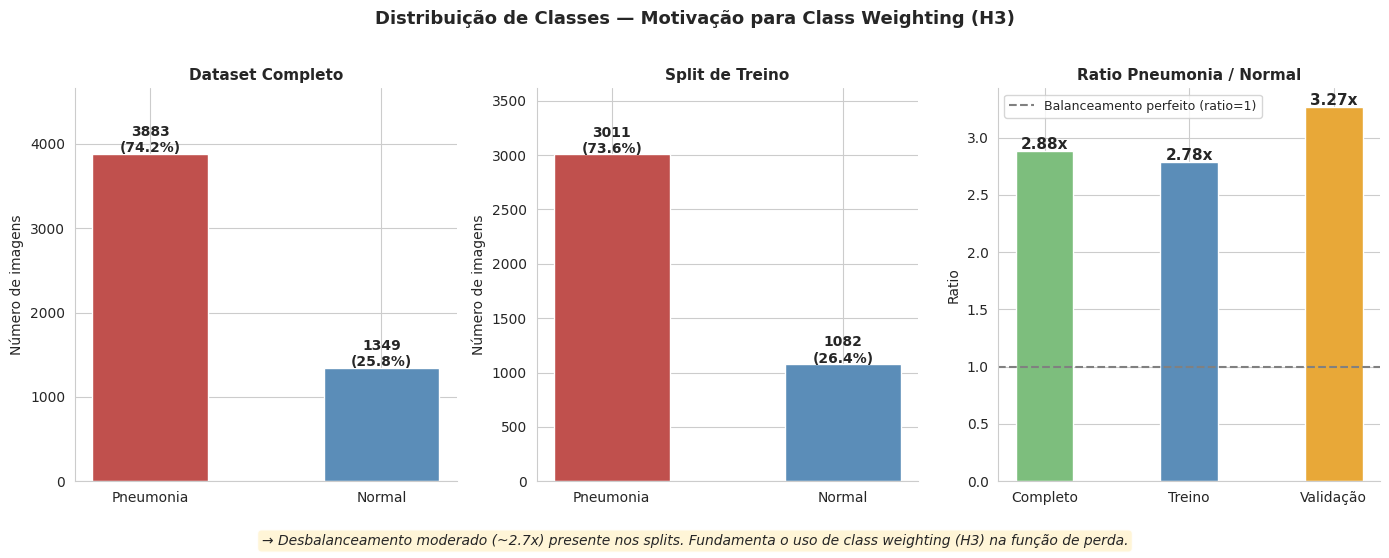

Salvo em: c:\projects\xray-project\outputs\figures\eda_distribuicao_classes.png


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
# Cria uma figura com 3 gráficos lado a lado (1 linha, 3 colunas)
# Isso permite comparar visualmente dataset completo, treino e o ratio

COLORS_CLASS = {"Normal": "#5B8DB8", "Pneumonia": "#C0504D"}
# Define cores fixas para cada classe
# Isso mantém consistência visual ao longo do projeto

# --- Plot 1: Dataset completo ---
counts_full = df["label"].value_counts().rename({0: "Normal", 1: "Pneumonia"})
# Conta quantas imagens existem por classe no dataset completo
# Renomeia 0 e 1 para nomes mais interpretáveis

bars = axes[0].bar(counts_full.index, counts_full.values,
                   color=[COLORS_CLASS[k] for k in counts_full.index],
                   edgecolor="white", width=0.5)
# Cria o gráfico de barras com cores correspondentes às classes

for bar, val in zip(bars, counts_full.values):
    pct = val / counts_full.sum() * 100
    # Calcula a porcentagem de cada classe no dataset
    
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+20,
                 f"{val}\n({pct:.1f}%)", ha="center", fontsize=10, fontweight="bold")
    # Adiciona o número absoluto e percentual acima da barra

axes[0].set_title("Dataset Completo", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Número de imagens", fontsize=10)
axes[0].set_ylim(0, max(counts_full.values) * 1.2)
# Ajusta limite do eixo Y para deixar espaço para os textos

axes[0].spines[["top","right"]].set_visible(False)
# Remove bordas superiores e direita para estética mais limpa


# --- Plot 2: Split Treino ---
counts_train = train_df["label"].value_counts().rename({0: "Normal", 1: "Pneumonia"})
# Conta a distribuição de classes apenas no conjunto de treino

bars2 = axes[1].bar(counts_train.index, counts_train.values,
                    color=[COLORS_CLASS[k] for k in counts_train.index],
                    edgecolor="white", width=0.5)
# Plota as barras com o mesmo padrão visual do gráfico anterior

for bar, val in zip(bars2, counts_train.values):
    pct = val / counts_train.sum() * 100
    # Calcula o percentual dentro do split de treino
    
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+10,
                 f"{val}\n({pct:.1f}%)", ha="center", fontsize=10, fontweight="bold")
    # Mostra quantidade absoluta e percentual acima de cada barra

axes[1].set_title("Split de Treino", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Número de imagens", fontsize=10)
axes[1].set_ylim(0, max(counts_train.values) * 1.2)
# Mantém escala proporcional para comparação visual

axes[1].spines[["top","right"]].set_visible(False)
# Remove bordas desnecessárias


# --- Plot 3: Ratio de desbalanceamento por split ---
ratios = {
    "Completo": counts_full.get("Pneumonia", 0) / counts_full.get("Normal", 1),
    "Treino":   counts_train.get("Pneumonia", 0) / counts_train.get("Normal", 1),
    "Validação": (val_df["label"]==1).sum() / max((val_df["label"]==0).sum(), 1),
}
# Calcula o ratio Pneumonia / Normal
# Se ratio = 1 → dataset balanceado
# Se ratio > 1 → mais Pneumonia que Normal
# Uso de .get() e max(...,1) evita divisão por zero

axes[2].bar(ratios.keys(), ratios.values(), color=["#7DBE7D","#5B8DB8","#E8A838"],
            edgecolor="white", width=0.4)
# Cria gráfico de barras mostrando o nível de desbalanceamento

axes[2].axhline(1.0, color="gray", linestyle="--", linewidth=1.5,
                label="Balanceamento perfeito (ratio=1)")
# Linha horizontal indicando equilíbrio ideal

for i, (k, v) in enumerate(ratios.items()):
    axes[2].text(i, v + 0.02, f"{v:.2f}x", ha="center",
                 fontsize=11, fontweight="bold")
    # Mostra o valor numérico do ratio acima de cada barra

axes[2].set_title("Ratio Pneumonia / Normal", fontsize=11, fontweight="bold")
axes[2].set_ylabel("Ratio", fontsize=10)
axes[2].legend(fontsize=9)
axes[2].spines[["top","right"]].set_visible(False)
# Ajustes visuais finais


fig.suptitle("Distribuição de Classes — Motivação para Class Weighting (H3)",
             fontsize=13, fontweight="bold", y=1.02)
# Título geral da figura, já conectando com a hipótese H3

# Caixa de decisão
fig.text(0.5, -0.05,
         "→ Desbalanceamento moderado (~2.7x) presente nos splits. "
         "Fundamenta o uso de class weighting (H3) na função de perda.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))
# Texto interpretativo que transforma o gráfico em decisão metodológica

plt.tight_layout()
# Ajusta espaçamentos internos automaticamente

save_path = os.path.join(figures_dir, "eda_distribuicao_classes.png")
# Define caminho para salvar a figura

plt.savefig(save_path, dpi=150, bbox_inches="tight")
# Salva a imagem com boa resolução para relatório/artigo

plt.show()
# Exibe o gráfico no notebook

print("Salvo em:", save_path)
# Confirma onde o arquivo foi salvo

## 4. Dimensões das Imagens — Motivação para Resize e Transfer Learning

**Achados que fundamentam:**
- Resize padronizado para 224×224 (padrão ImageNet)
- Transfer Learning: dataset de tamanho moderado não justifica treino do zero
- CenterCrop de 90% para reduzir artefatos periféricos

In [4]:
print("Coletando dimensões das imagens (amostra de 300)...")
# Mensagem inicial apenas para indicar que a análise das dimensões começou

sample_df = df.sample(min(300, len(df)), random_state=42)
# Seleciona uma amostra aleatória de até 300 imagens do dataframe
# Se o dataset tiver menos de 300 imagens, pega todas
# random_state=42 garante que a mesma amostra será escolhida sempre (reprodutibilidade)

widths, heights, aspects = [], [], []  # listas vazias
# widths  → vai armazenar as larguras das imagens
# heights → vai armazenar as alturas das imagens
# aspects → vai armazenar a razão largura/altura (aspect ratio)

for path in sample_df["path"]:
    # Percorre o caminho (path) de cada imagem presente na amostra
    
    try:
        img = Image.open(path)
        # Abre a imagem a partir do caminho
        
        w, h = img.size  # armazena largura e altura de cada imagem nas listas
        # img.size retorna (largura, altura)
        
        widths.append(w)
        # Adiciona a largura na lista widths
        
        heights.append(h)
        # Adiciona a altura na lista heights
        
        aspects.append(w / h)
        # Calcula e armazena a proporção largura/altura
        # Isso ajuda a entender o formato das imagens (mais retangular ou mais quadrada)
        
    except Exception:
        pass
        # Caso ocorra erro ao abrir alguma imagem (arquivo corrompido, por exemplo),
        # o código simplesmente ignora e continua para a próxima

print(f"Largura — min: {min(widths)}, max: {max(widths)}, média: {np.mean(widths):.0f}")
# Exibe a menor largura encontrada, a maior largura e a média das larguras

print(f"Altura  — min: {min(heights)}, max: {max(heights)}, média: {np.mean(heights):.0f}")
# Exibe a menor altura encontrada, a maior altura e a média das alturas

print(f"Total de imagens no dataset: {len(df)}")
# Mostra o total de imagens no dataset completo (não apenas na amostra)

print()
# Apenas uma quebra de linha para organizar a saída

# Categorias de tamanho
n_pequenas  = sum(1 for w, h in zip(widths, heights) if w < 500 or h < 500)
# Conta imagens consideradas pequenas
# Critério: largura OU altura menor que 500 pixels

n_medias    = sum(1 for w, h in zip(widths, heights) if 500 <= w <= 1500 and 500 <= h <= 1500)
# Conta imagens médias
# Critério: largura E altura entre 500 e 1500 pixels

n_grandes   = sum(1 for w, h in zip(widths, heights) if w > 1500 or h > 1500)
# Conta imagens grandes
# Critério: largura OU altura maior que 1500 pixels

print(f"Imagens pequenas (<500px):  {n_pequenas}")
# Mostra a quantidade de imagens pequenas

print(f"Imagens médias (500-1500px): {n_medias}")
# Mostra a quantidade de imagens médias

print(f"Imagens grandes (>1500px):  {n_grandes}")
# Mostra a quantidade de imagens grandes

Coletando dimensões das imagens (amostra de 300)...
Largura — min: 438, max: 2566, média: 1339
Altura  — min: 132, max: 2519, média: 978
Total de imagens no dataset: 5232

Imagens pequenas (<500px):  17
Imagens médias (500-1500px): 188
Imagens grandes (>1500px):  95


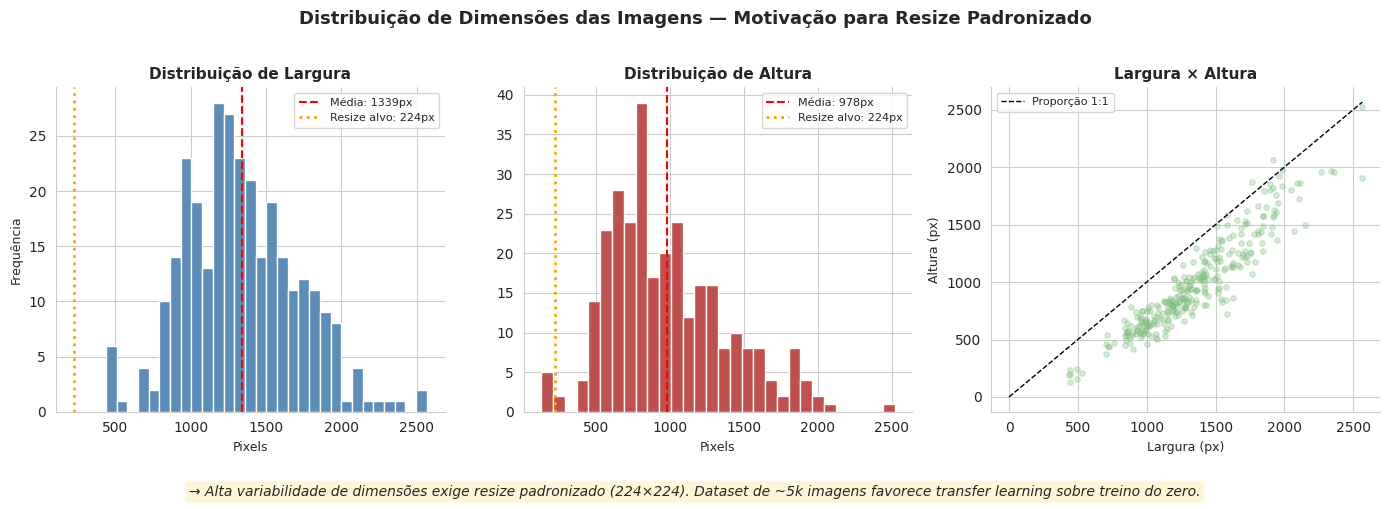

Salvo em: c:\projects\xray-project\outputs\figures\eda_dimensoes.png


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
# Cria uma figura com 3 gráficos lado a lado (1 linha, 3 colunas)
# figsize define o tamanho da figura para ficar proporcional e legível

# Largura
axes[0].hist(widths, bins=30, color="#5B8DB8", edgecolor="white")
# Histograma das larguras das imagens
# bins=30 divide os valores em 30 intervalos
# color e edgecolor são apenas ajustes visuais

axes[0].axvline(np.mean(widths), color="red", linestyle="--",
                linewidth=1.5, label=f"Média: {np.mean(widths):.0f}px")
# Linha vertical indicando a média das larguras
# Serve para visualizar onde está o valor médio no conjunto

axes[0].axvline(224, color="orange", linestyle=":",
                linewidth=2, label="Resize alvo: 224px")
# Linha vertical indicando o tamanho alvo (224px)
# Isso ajuda a comparar o tamanho original com o tamanho que será usado no modelo

axes[0].set_title("Distribuição de Largura", fontsize=11, fontweight="bold")
# Define o título do gráfico

axes[0].set_xlabel("Pixels", fontsize=9)
# Nome do eixo x

axes[0].set_ylabel("Frequência", fontsize=9)
# Nome do eixo y (quantidade de imagens em cada faixa)

axes[0].legend(fontsize=8)
# Mostra a legenda explicando as linhas

axes[0].spines[["top","right"]].set_visible(False)
# Remove bordas superior e direita para deixar o gráfico mais limpo


# Altura
axes[1].hist(heights, bins=30, color="#C0504D", edgecolor="white")
# Histograma das alturas das imagens

axes[1].axvline(np.mean(heights), color="red", linestyle="--",
                linewidth=1.5, label=f"Média: {np.mean(heights):.0f}px")
# Linha vertical mostrando a média das alturas

axes[1].axvline(224, color="orange", linestyle=":",
                linewidth=2, label="Resize alvo: 224px")
# Linha indicando novamente o tamanho alvo de entrada da CNN

axes[1].set_title("Distribuição de Altura", fontsize=11, fontweight="bold")
# Título do gráfico

axes[1].set_xlabel("Pixels", fontsize=9)
# Nome do eixo x

axes[1].legend(fontsize=8)
# Legenda com média e resize alvo

axes[1].spines[["top","right"]].set_visible(False)
# Remove bordas desnecessárias


# Scatter Largura x Altura
axes[2].scatter(widths, heights, alpha=0.3, s=15, color="#7DBE7D")
# Gráfico de dispersão mostrando largura vs altura
# alpha controla transparência (melhor para muitos pontos)
# s define o tamanho dos pontos

axes[2].plot([0, max(max(widths), max(heights))],
             [0, max(max(widths), max(heights))],
             "k--", linewidth=1, label="Proporção 1:1")
# Linha diagonal representando proporção 1:1 (largura = altura)
# Ajuda a visualizar se as imagens são mais quadradas ou retangulares

axes[2].set_title("Largura × Altura", fontsize=11, fontweight="bold")
# Título do gráfico

axes[2].set_xlabel("Largura (px)", fontsize=9)
# Nome do eixo x

axes[2].set_ylabel("Altura (px)", fontsize=9)
# Nome do eixo y

axes[2].legend(fontsize=8)
# Legenda indicando a linha de proporção 1:1

axes[2].spines[["top","right"]].set_visible(False)
# Remove bordas superiores e direita


fig.suptitle("Distribuição de Dimensões das Imagens — Motivação para Resize Padronizado",
             fontsize=13, fontweight="bold", y=1.02)
# Título geral da figura (acima dos três gráficos)
# Ele já indica o objetivo da análise: justificar o resize padronizado

fig.text(0.5, -0.06,
         "→ Alta variabilidade de dimensões exige resize padronizado (224×224). "
         "Dataset de ~5k imagens favorece transfer learning sobre treino do zero.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))
# Texto explicativo abaixo dos gráficos
# Resume a interpretação da análise:
# 1) Há grande variação nas dimensões
# 2) Resize padronizado é necessário
# 3) Dataset relativamente pequeno favorece transfer learning

plt.tight_layout()
# Ajusta automaticamente os espaçamentos para evitar sobreposição

save_path = os.path.join(figures_dir, "eda_dimensoes.png")
# Define o caminho onde a figura será salva

plt.savefig(save_path, dpi=150, bbox_inches="tight")
# Salva a imagem com resolução adequada para relatório
# bbox_inches="tight" remove espaços extras ao redor

plt.show()
# Exibe a figura no notebook

print("Salvo em:", save_path)
# Mostra o caminho onde o arquivo foi salvo

## 5. Distribuição de Intensidade de Pixels por Classe

**Achados que fundamentam:**
- Diferenças de textura e densidade entre Normal e Pneumonia
- Normalização com média/std do ImageNet
- CNNs como escolha arquitetural (capturam padrões espaciais/texturais)

Imagens de pneumonia tendem a apresentar maior densidade
em regiões pulmonares (consolidações, infiltrados),
refletindo em distribuições de intensidade distintas.

In [6]:
print("Calculando histogramas por classe (amostra de 150 por classe)...")

pixels_normal    = []
pixels_pneumonia = []
means_normal, means_pneumonia = [], []
stds_normal,  stds_pneumonia  = [], []

sample_normal    = df[df["label"] == 0].sample(min(150, (df["label"]==0).sum()), random_state=42)
sample_pneumonia = df[df["label"] == 1].sample(min(150, (df["label"]==1).sum()), random_state=42)

for path in sample_normal["path"]:
    try:
        arr = np.array(Image.open(path).convert("L").resize((224, 224))).flatten()
        pixels_normal.extend(arr)
        means_normal.append(arr.mean())
        stds_normal.append(arr.std())
    except Exception:
        pass

for path in sample_pneumonia["path"]:
    try:
        arr = np.array(Image.open(path).convert("L").resize((224, 224))).flatten()
        pixels_pneumonia.extend(arr)
        means_pneumonia.append(arr.mean())
        stds_pneumonia.append(arr.std())
    except Exception:
        pass

print(f"Normal    — média de intensidade: {np.mean(means_normal):.1f} ± {np.std(means_normal):.1f}")
print(f"Pneumonia — média de intensidade: {np.mean(means_pneumonia):.1f} ± {np.std(means_pneumonia):.1f}")

Calculando histogramas por classe (amostra de 150 por classe)...
Normal    — média de intensidade: 122.7 ± 13.3
Pneumonia — média de intensidade: 123.4 ± 19.4


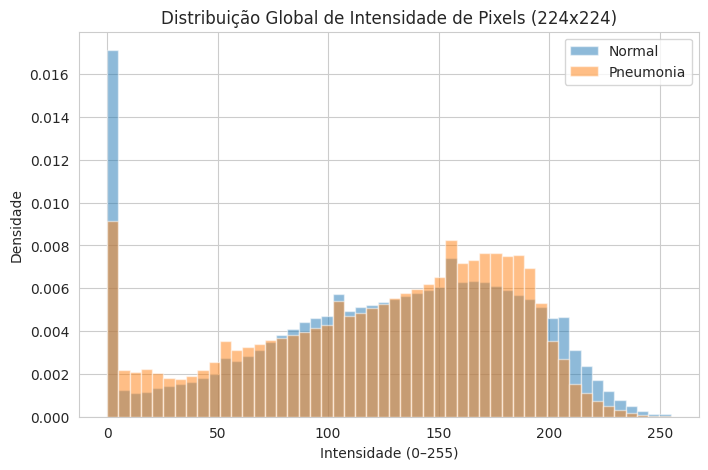

In [7]:
# visualizar a distribuição

plt.figure(figsize=(8,5))

plt.hist(pixels_normal, bins=50, alpha=0.5, density=True, label="Normal")
plt.hist(pixels_pneumonia, bins=50, alpha=0.5, density=True, label="Pneumonia")

plt.title("Distribuição Global de Intensidade de Pixels (224x224)")
plt.xlabel("Intensidade (0–255)")
plt.ylabel("Densidade")
plt.legend()
plt.show()

A análise dos histogramas de intensidade média por classe revela distribuições unimodais e fortemente sobrepostas entre Normal e Pneumonia. Isso indica que não há separabilidade adequada por meio de um limiar global de intensidade, pois qualquer threshold escolhido resultaria em elevada taxa de erro devido à ampla interseção entre as classes. Assim, o problema não é discriminável por estatísticas fotométricas globais, mas por padrões estruturais e espaciais locais, como consolidações e infiltrados, cuja relevância depende da organização espacial dos pixels. Essa limitação justifica a aplicação de Redes Neurais Convolucionais (CNNs), capazes de aprender representações hierárquicas que capturam texturas, regiões anatômicas e padrões morfológicos complexos, explorando precisamente a informação espacial que um critério baseado em intensidade média não consegue modelar.

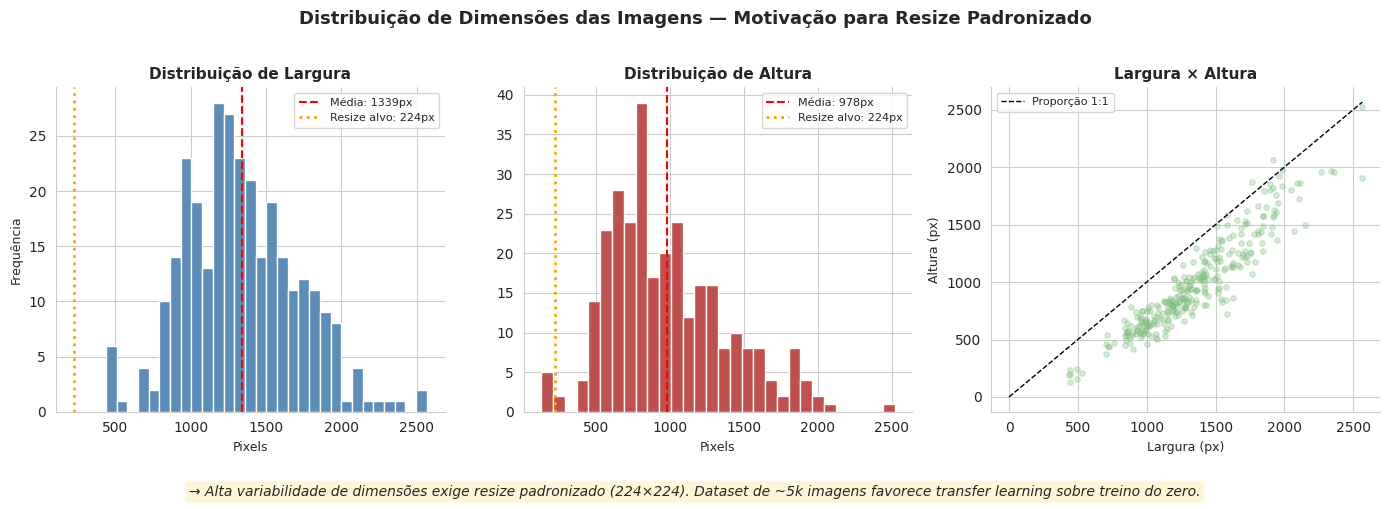

Salvo em: c:\projects\xray-project\outputs\figures\eda_dimensoes.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
# Cria uma figura com 3 gráficos lado a lado (1 linha, 3 colunas)
# figsize define o tamanho da figura para ficar proporcional e legível

# Largura
axes[0].hist(widths, bins=30, color="#5B8DB8", edgecolor="white")
# Histograma das larguras das imagens
# bins=30 divide os valores em 30 intervalos
# color e edgecolor são apenas ajustes visuais

axes[0].axvline(np.mean(widths), color="red", linestyle="--",
                linewidth=1.5, label=f"Média: {np.mean(widths):.0f}px")
# Linha vertical indicando a média das larguras
# Serve para visualizar onde está o valor médio no conjunto

axes[0].axvline(224, color="orange", linestyle=":",
                linewidth=2, label="Resize alvo: 224px")
# Linha vertical indicando o tamanho alvo (224px)
# Isso ajuda a comparar o tamanho original com o tamanho que será usado no modelo

axes[0].set_title("Distribuição de Largura", fontsize=11, fontweight="bold")
# Define o título do gráfico

axes[0].set_xlabel("Pixels", fontsize=9)
# Nome do eixo x

axes[0].set_ylabel("Frequência", fontsize=9)
# Nome do eixo y (quantidade de imagens em cada faixa)

axes[0].legend(fontsize=8)
# Mostra a legenda explicando as linhas

axes[0].spines[["top","right"]].set_visible(False)
# Remove bordas superior e direita para deixar o gráfico mais limpo


# Altura
axes[1].hist(heights, bins=30, color="#C0504D", edgecolor="white")
# Histograma das alturas das imagens

axes[1].axvline(np.mean(heights), color="red", linestyle="--",
                linewidth=1.5, label=f"Média: {np.mean(heights):.0f}px")
# Linha vertical mostrando a média das alturas

axes[1].axvline(224, color="orange", linestyle=":",
                linewidth=2, label="Resize alvo: 224px")
# Linha indicando novamente o tamanho alvo de entrada da CNN

axes[1].set_title("Distribuição de Altura", fontsize=11, fontweight="bold")
# Título do gráfico

axes[1].set_xlabel("Pixels", fontsize=9)
# Nome do eixo x

axes[1].legend(fontsize=8)
# Legenda com média e resize alvo

axes[1].spines[["top","right"]].set_visible(False)
# Remove bordas desnecessárias


# Scatter Largura x Altura
axes[2].scatter(widths, heights, alpha=0.3, s=15, color="#7DBE7D")
# Gráfico de dispersão mostrando largura vs altura
# alpha controla transparência (melhor para muitos pontos)
# s define o tamanho dos pontos

axes[2].plot([0, max(max(widths), max(heights))],
             [0, max(max(widths), max(heights))],
             "k--", linewidth=1, label="Proporção 1:1")
# Linha diagonal representando proporção 1:1 (largura = altura)
# Ajuda a visualizar se as imagens são mais quadradas ou retangulares

axes[2].set_title("Largura × Altura", fontsize=11, fontweight="bold")
# Título do gráfico

axes[2].set_xlabel("Largura (px)", fontsize=9)
# Nome do eixo x

axes[2].set_ylabel("Altura (px)", fontsize=9)
# Nome do eixo y

axes[2].legend(fontsize=8)
# Legenda indicando a linha de proporção 1:1

axes[2].spines[["top","right"]].set_visible(False)
# Remove bordas superiores e direita


fig.suptitle("Distribuição de Dimensões das Imagens — Motivação para Resize Padronizado",
             fontsize=13, fontweight="bold", y=1.02)
# Título geral da figura (acima dos três gráficos)
# Ele já indica o objetivo da análise: justificar o resize padronizado

fig.text(0.5, -0.06,
         "→ Alta variabilidade de dimensões exige resize padronizado (224×224). "
         "Dataset de ~5k imagens favorece transfer learning sobre treino do zero.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))
# Texto explicativo abaixo dos gráficos
# Resume a interpretação da análise:
# 1) Há grande variação nas dimensões
# 2) Resize padronizado é necessário
# 3) Dataset relativamente pequeno favorece transfer learning

plt.tight_layout()
# Ajusta automaticamente os espaçamentos para evitar sobreposição

save_path = os.path.join(figures_dir, "eda_dimensoes.png")
# Define o caminho onde a figura será salva

plt.savefig(save_path, dpi=150, bbox_inches="tight")
# Salva a imagem com resolução adequada para relatório
# bbox_inches="tight" remove espaços extras ao redor

plt.show()
# Exibe a figura no notebook

print("Salvo em:", save_path)
# Mostra o caminho onde o arquivo foi salvo

## 6. Galeria Visual — Padrões Diagnósticos por Classe

Visualização comparativa de exemplos representativos de cada classe,
ilustrando os padrões visuais que os modelos devem aprender.

**O que observar:**
- **Normal**: campos pulmonares translúcidos, costelas bem definidas, sem opacidades
- **Pneumonia**: consolidações (regiões opacas/brancas), infiltrados, assimetrias

Esses padrões são espacialmente distribuídos e de textura variável,
justificando o uso de CNNs com filtros hierárquicos.

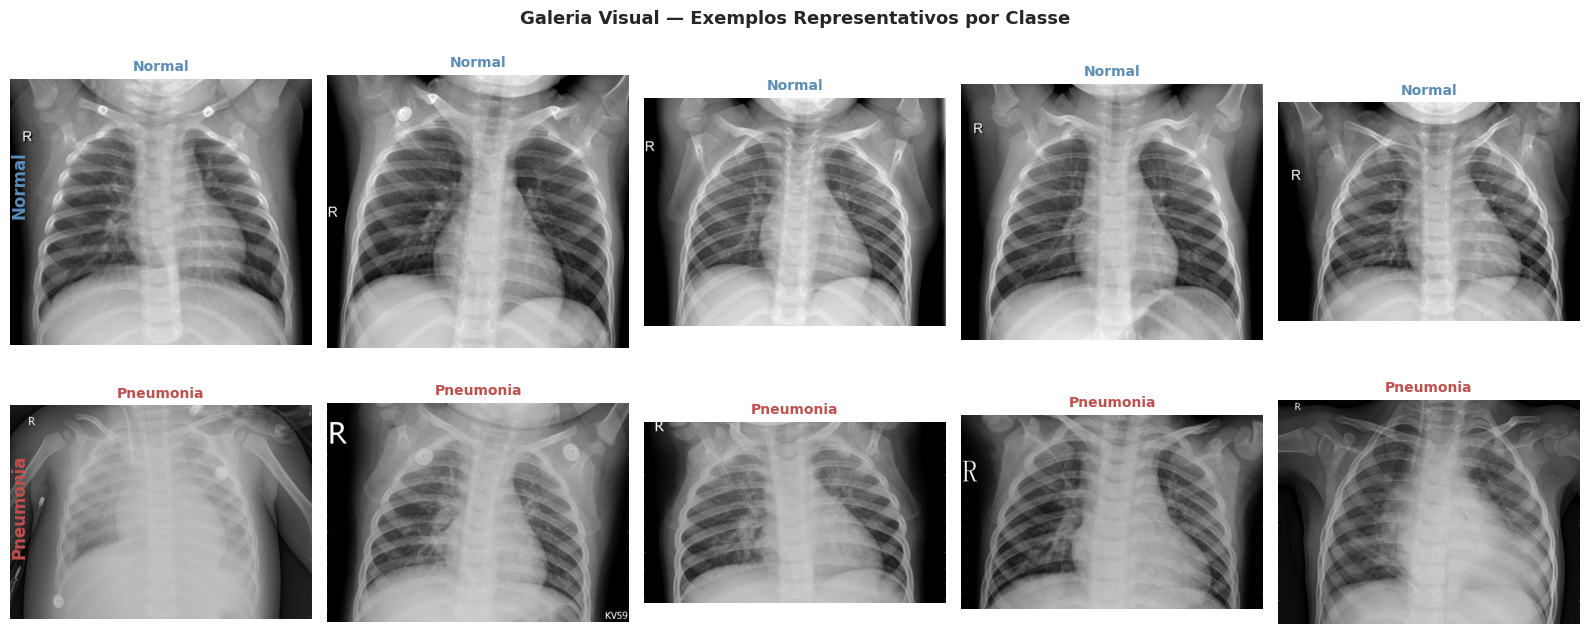

Salvo em: c:\projects\xray-project\outputs\figures\eda_galeria_visual.png


In [9]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
# Cria uma figura com 2 linhas e 5 colunas de subplots
# Linha 0 → classe Normal
# Linha 1 → classe Pneumonia
# figsize define o tamanho total da figura

normal_samples    = df[df["label"] == 0].sample(5, random_state=42)
# Seleciona 5 imagens aleatórias da classe Normal
# random_state garante reprodutibilidade (mesmas imagens sempre)

pneumonia_samples = df[df["label"] == 1].sample(5, random_state=42)
# Seleciona 5 imagens aleatórias da classe Pneumonia

for i, (_, row) in enumerate(normal_samples.iterrows()):
    # Percorre as 5 imagens da classe Normal
    
    img = Image.open(row["path"]).convert("RGB")
    # Abre a imagem e converte para RGB
    
    axes[0, i].imshow(img, cmap="gray")
    # Exibe a imagem na primeira linha da grade
    # cmap="gray" tenta mostrar em escala de cinza
    
    axes[0, i].set_title(f"Normal", fontsize=10, color="#5B8DB8", fontweight="bold")
    # Define o título acima de cada imagem
    
    axes[0, i].axis("off")
    # Remove eixos para visualização mais limpa


for i, (_, row) in enumerate(pneumonia_samples.iterrows()):
    # Percorre as 5 imagens da classe Pneumonia
    
    img = Image.open(row["path"]).convert("RGB")
    # Abre a imagem e converte para RGB
    
    axes[1, i].imshow(img, cmap="gray")
    # Exibe a imagem na segunda linha da grade
    
    axes[1, i].set_title(f"Pneumonia", fontsize=10, color="#C0504D", fontweight="bold")
    # Define o título correspondente
    
    axes[1, i].axis("off")
    # Remove eixos


fig.suptitle("Galeria Visual — Exemplos Representativos por Classe",
             fontsize=13, fontweight="bold")
# Define o título principal da figura


# Anotações de linha
fig.text(0.01, 0.73, "Normal", va="center", ha="left", rotation=90,
         fontsize=12, color="#5B8DB8", fontweight="bold")
# Adiciona rótulo vertical à esquerda da primeira linha

fig.text(0.01, 0.27, "Pneumonia", va="center", ha="left", rotation=90,
         fontsize=12, color="#C0504D", fontweight="bold")
# Adiciona rótulo vertical à esquerda da segunda linha


plt.tight_layout()
# Ajusta automaticamente os espaçamentos entre subplots

save_path = os.path.join(figures_dir, "eda_galeria_visual.png")
# Define o caminho onde a imagem será salva

plt.savefig(save_path, dpi=150, bbox_inches="tight")
# Salva a figura com resolução adequada para relatório

plt.show()
# Exibe a figura no notebook

print("Salvo em:", save_path)
# Mostra o caminho onde a imagem foi salva

## 7. Análise de Artefatos Periféricos — Motivação para CenterCrop

Imagens de raio-X clínicas frequentemente contêm:
- Bordas escuras (padding do detector)
- Marcações hospitalares (texto, logos)
- Dispositivos médicos (drenos, cabos de monitor)

O CenterCrop de 90% do resize remove sistematicamente
as bordas externas, reduzindo o risco de o modelo
aprender esses artefatos como features discriminativas.

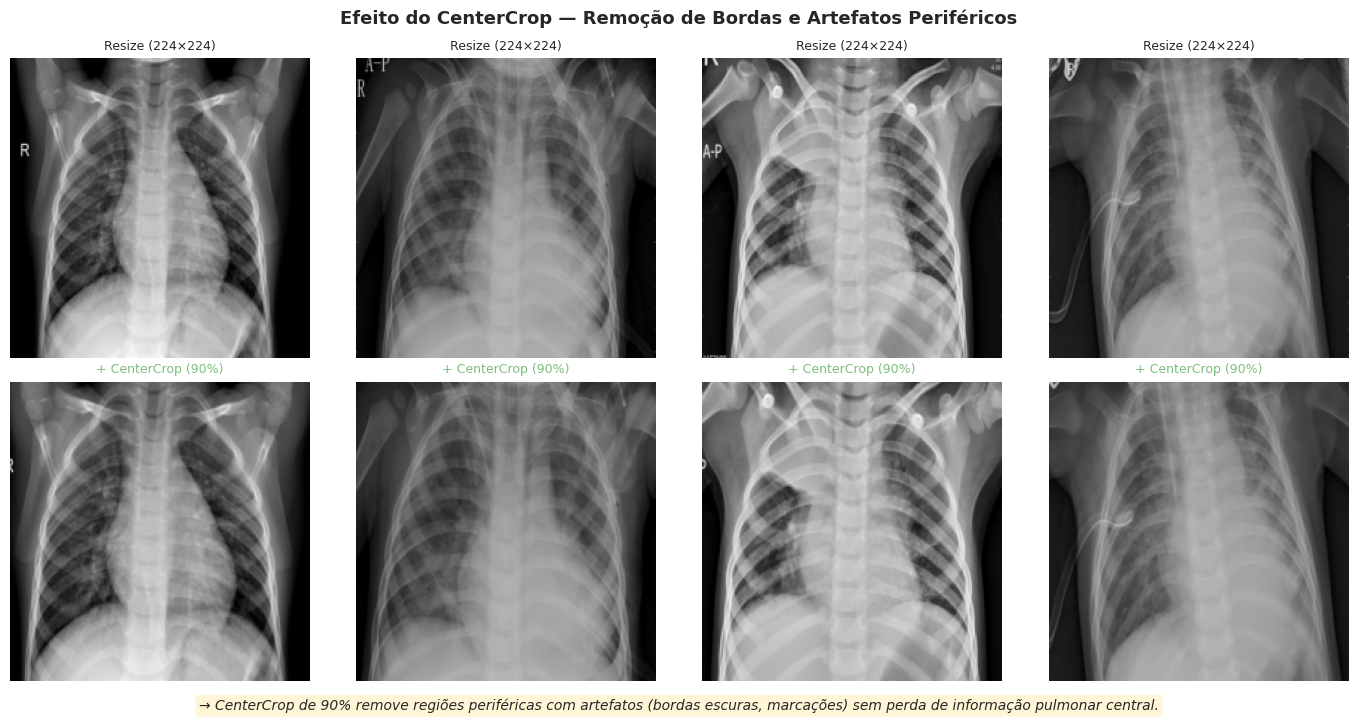

Salvo em: c:\projects\xray-project\outputs\figures\eda_centercrop.png


In [10]:
from torchvision import transforms

# Transformações para demonstração
resize_only = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

with_centercrop = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(int(224 * 0.9)),  # 201px
    transforms.ToTensor(),
])

sample_paths = df.sample(4, random_state=7)["path"].tolist()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i, path in enumerate(sample_paths):
    img_pil = Image.open(path).convert("RGB")

    # Resize apenas
    img_resize = transforms.Compose([transforms.Resize((224, 224))])(img_pil)
    axes[0, i].imshow(img_resize, cmap="gray")
    axes[0, i].set_title("Resize (224×224)", fontsize=9)
    axes[0, i].axis("off")

    # Com CenterCrop
    img_crop = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(int(224 * 0.9))
    ])(img_pil)
    axes[1, i].imshow(img_crop, cmap="gray")
    axes[1, i].set_title("+ CenterCrop (90%)", fontsize=9, color="#7DBE7D")
    axes[1, i].axis("off")

    # Destacar bordas removidas
    for ax in [axes[0, i], axes[1, i]]:
        for spine in ax.spines.values():
            spine.set_visible(True)

fig.suptitle("Efeito do CenterCrop — Remoção de Bordas e Artefatos Periféricos",
             fontsize=13, fontweight="bold")

fig.text(0.5, -0.02,
         "→ CenterCrop de 90% remove regiões periféricas com artefatos "
         "(bordas escuras, marcações) sem perda de informação pulmonar central.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))

plt.tight_layout()
save_path = os.path.join(figures_dir, "eda_centercrop.png")
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()
print("Salvo em:", save_path)

## 8. Análise de Data Augmentation — Motivação para H2

Visualização comparativa entre o augmentation leve (Baseline)
e o augmentation forte (H2), aplicados sobre a mesma imagem.

**Hipótese 2:** augmentation mais intenso atuaria como regularização,
reduzindo sobreajuste e melhorando generalização.

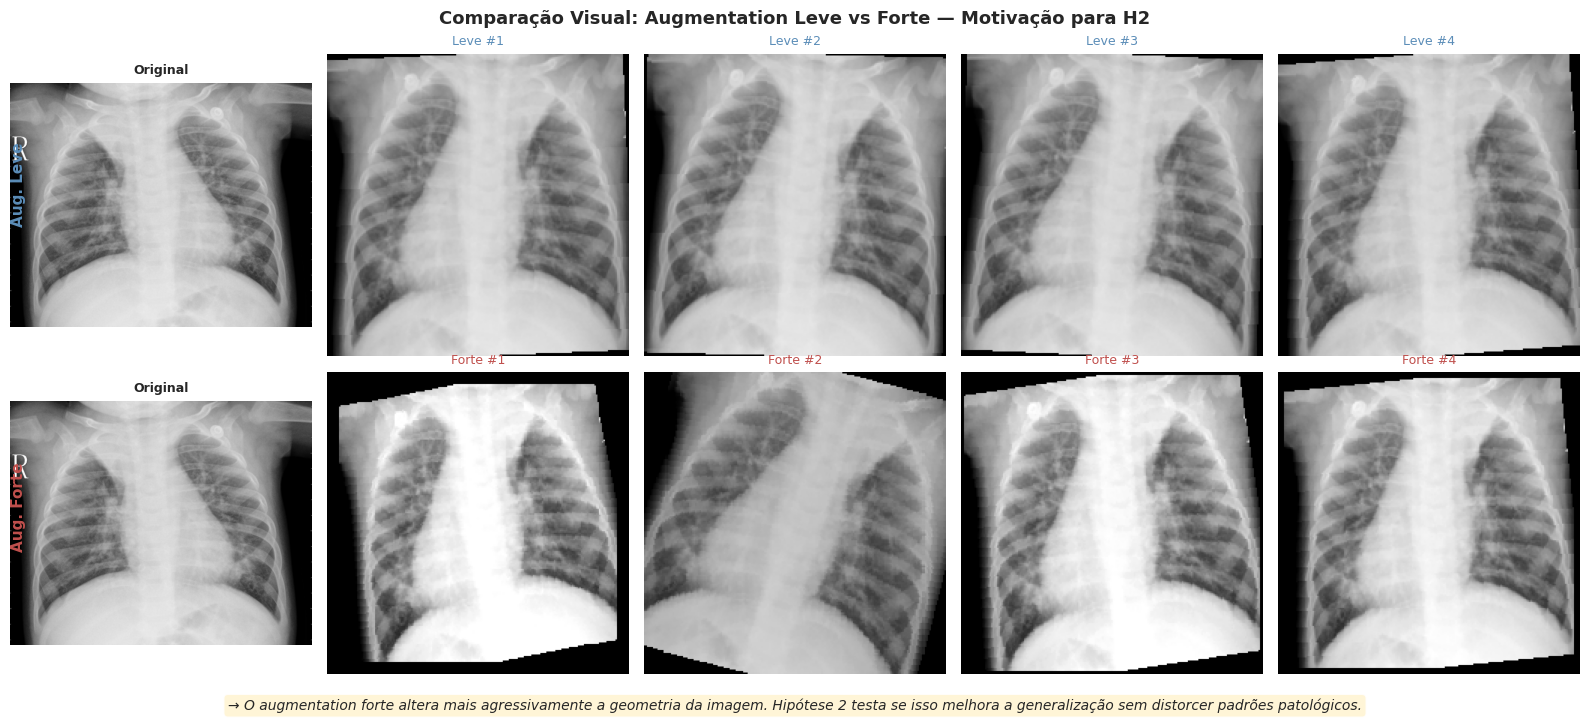

Salvo em: c:\projects\xray-project\outputs\figures\eda_augmentation.png


In [11]:
aug_light = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(int(224 * 0.9)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(5),
])

aug_strong = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(int(224 * 0.9)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# Usar a mesma imagem para comparação
sample_path = df[df["label"] == 1].sample(1, random_state=10)["path"].values[0]
original    = Image.open(sample_path).convert("RGB")

fig, axes = plt.subplots(2, 5, figsize=(16, 7))

# Linha 0: Augmentation Leve
axes[0, 0].imshow(original, cmap="gray")
axes[0, 0].set_title("Original", fontsize=9, fontweight="bold")
axes[0, 0].axis("off")

for j in range(1, 5):
    aug_img = aug_light(original)
    axes[0, j].imshow(aug_img, cmap="gray")
    axes[0, j].set_title(f"Leve #{j}", fontsize=9, color="#5B8DB8")
    axes[0, j].axis("off")

# Linha 1: Augmentation Forte
axes[1, 0].imshow(original, cmap="gray")
axes[1, 0].set_title("Original", fontsize=9, fontweight="bold")
axes[1, 0].axis("off")

for j in range(1, 5):
    aug_img = aug_strong(original)
    axes[1, j].imshow(aug_img, cmap="gray")
    axes[1, j].set_title(f"Forte #{j}", fontsize=9, color="#C0504D")
    axes[1, j].axis("off")

fig.text(0.01, 0.73, "Aug. Leve", va="center", ha="left", rotation=90,
         fontsize=11, color="#5B8DB8", fontweight="bold")
fig.text(0.01, 0.27, "Aug. Forte", va="center", ha="left", rotation=90,
         fontsize=11, color="#C0504D", fontweight="bold")

fig.suptitle("Comparação Visual: Augmentation Leve vs Forte — Motivação para H2",
             fontsize=13, fontweight="bold")

fig.text(0.5, -0.02,
         "→ O augmentation forte altera mais agressivamente a geometria da imagem. "
         "Hipótese 2 testa se isso melhora a generalização sem distorcer padrões patológicos.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))

plt.tight_layout()
save_path = os.path.join(figures_dir, "eda_augmentation.png")
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()
print("Salvo em:", save_path)

## 9. Variabilidade Visual Intra-Classe — Motivação para Transfer Learning e H1

A variabilidade dentro de cada classe (diferentes pacientes,
idades, posicionamentos) impõe desafios adicionais ao modelo.

- **Alta variabilidade intra-classe** → Transfer Learning é essencial
  (representações genéricas do ImageNet aceleram convergência)
- **Padrões sutis em alguns casos** → Motivou testar DenseNet121 (H1),
  que propaga features de forma mais densa entre camadas

Calculando variância intra-classe...
Variância intra-classe Normal:    0.01749
Variância intra-classe Pneumonia: 0.02081


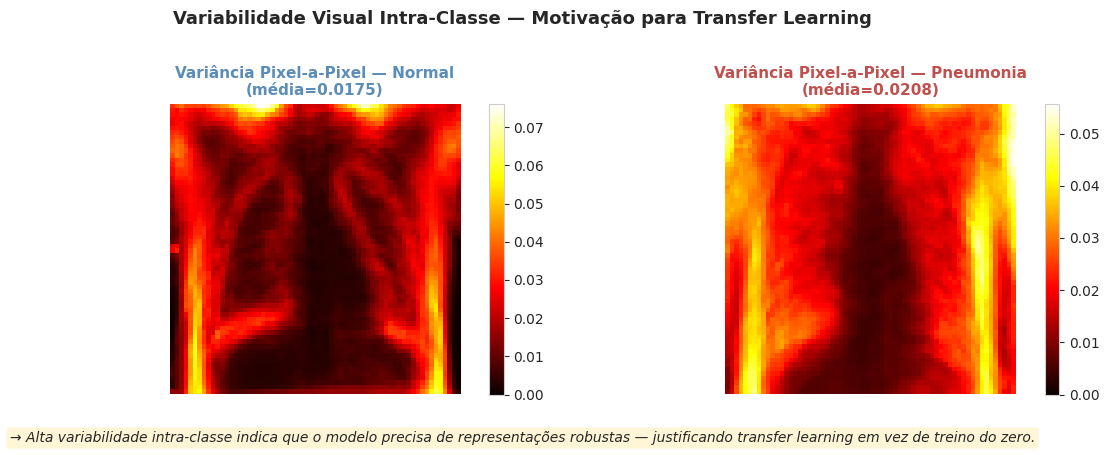

Salvo em: c:\projects\xray-project\outputs\figures\eda_variabilidade_intraclasse.png


In [12]:
# Calcular variância média dentro de cada classe
print("Calculando variância intra-classe...")

def get_image_vector(path, size=64):
    """Retorna imagem como vetor normalizado para comparação."""
    try:
        return np.array(Image.open(path).convert("L").resize((size, size))).flatten() / 255.0
    except Exception:
        return None

n_sample = 100
vecs_normal    = [v for path in df[df["label"]==0].sample(n_sample, random_state=42)["path"]
                  if (v := get_image_vector(path)) is not None]
vecs_pneumonia = [v for path in df[df["label"]==1].sample(n_sample, random_state=42)["path"]
                  if (v := get_image_vector(path)) is not None]

var_normal    = np.var(np.stack(vecs_normal),    axis=0).mean()
var_pneumonia = np.var(np.stack(vecs_pneumonia), axis=0).mean()

print(f"Variância intra-classe Normal:    {var_normal:.5f}")
print(f"Variância intra-classe Pneumonia: {var_pneumonia:.5f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Mapa de variância pixel-a-pixel
var_map_normal    = np.var(np.stack(vecs_normal),    axis=0).reshape(64, 64)
var_map_pneumonia = np.var(np.stack(vecs_pneumonia), axis=0).reshape(64, 64)

im0 = axes[0].imshow(var_map_normal, cmap="hot", vmin=0)
axes[0].set_title(f"Variância Pixel-a-Pixel — Normal\n(média={var_normal:.4f})",
                  fontsize=11, fontweight="bold", color="#5B8DB8")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(var_map_pneumonia, cmap="hot", vmin=0)
axes[1].set_title(f"Variância Pixel-a-Pixel — Pneumonia\n(média={var_pneumonia:.4f})",
                  fontsize=11, fontweight="bold", color="#C0504D")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

fig.suptitle("Variabilidade Visual Intra-Classe — Motivação para Transfer Learning",
             fontsize=13, fontweight="bold", y=1.02)

fig.text(0.5, -0.06,
         "→ Alta variabilidade intra-classe indica que o modelo precisa de "
         "representações robustas — justificando transfer learning em vez de treino do zero.",
         ha="center", fontsize=10, style="italic",
         bbox=dict(boxstyle="round", facecolor="#FFF3CD", alpha=0.8))

plt.tight_layout()
save_path = os.path.join(figures_dir, "eda_variabilidade_intraclasse.png")
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()
print("Salvo em:", save_path)

A análise de variância intra-classe revela que a Pneumonia apresenta maior heterogeneidade visual nas regiões periféricas do tórax. Dado que essas regiões concentram também artefatos típicos de aquisição radiológica — bordas escuras do detector, marcações hospitalares, variações de posicionamento — existe risco de que o modelo aprenda correlações espúrias entre ruído periférico e a classe positiva. Para mitigar esse risco, foi adotado um CenterCrop de 90% após o resize, removendo sistematicamente as bordas externas e restringindo o campo de atenção do modelo às regiões anatomicamente informativas.

## 10. Síntese da EDA — Mapa de Decisões

Figura consolidada conectando cada achado à sua decisão metodológica.

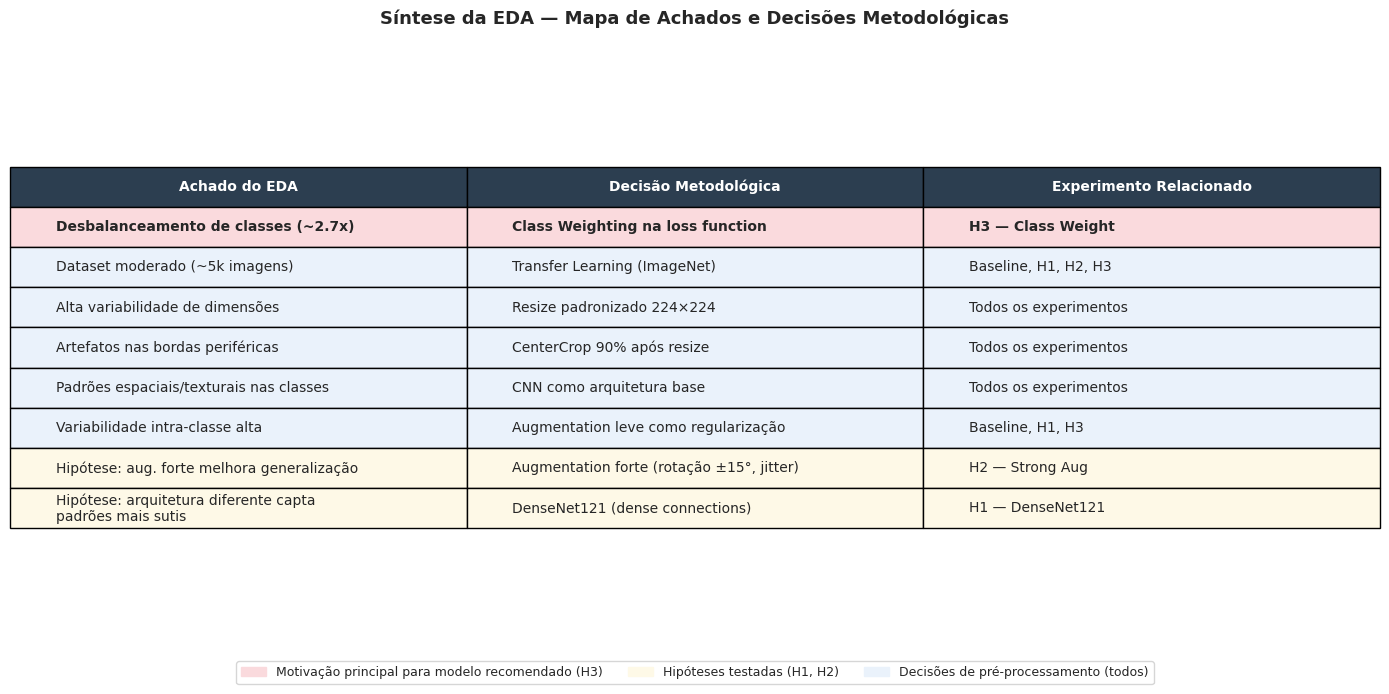

Salvo em: c:\projects\xray-project\outputs\figures\eda_mapa_decisoes.png


In [13]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.axis("off")

# Dados da tabela
table_data = [
    ["Desbalanceamento de classes (~2.7x)",
     "Class Weighting na loss function",
     "H3 — Class Weight"],
    ["Dataset moderado (~5k imagens)",
     "Transfer Learning (ImageNet)",
     "Baseline, H1, H2, H3"],
    ["Alta variabilidade de dimensões",
     "Resize padronizado 224×224",
     "Todos os experimentos"],
    ["Artefatos nas bordas periféricas",
     "CenterCrop 90% após resize",
     "Todos os experimentos"],
    ["Padrões espaciais/texturais nas classes",
     "CNN como arquitetura base",
     "Todos os experimentos"],
    ["Variabilidade intra-classe alta",
     "Augmentation leve como regularização",
     "Baseline, H1, H3"],
    ["Hipótese: aug. forte melhora generalização",
     "Augmentation forte (rotação ±15°, jitter)",
     "H2 — Strong Aug"],
    ["Hipótese: arquitetura diferente capta\npadrões mais sutis",
     "DenseNet121 (dense connections)",
     "H1 — DenseNet121"],
]

col_labels = ["Achado do EDA", "Decisão Metodológica", "Experimento Relacionado"]
col_colors = [["#2C3E50"] * 3]

row_colors_map = [
    "#FADADD",  # H3 - destaque
    "#EAF2FB",
    "#EAF2FB",
    "#EAF2FB",
    "#EAF2FB",
    "#EAF2FB",
    "#FEF9E7",
    "#FEF9E7",
]

table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    loc="center",
    cellLoc="left"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Estilo do header
for col in range(3):
    table[0, col].set_facecolor("#2C3E50")
    table[0, col].set_text_props(color="white", fontweight="bold")

# Cores das linhas
for row_idx, color in enumerate(row_colors_map, start=1):
    for col in range(3):
        table[row_idx, col].set_facecolor(color)

# Negrito na linha do H3
for col in range(3):
    table[1, col].set_text_props(fontweight="bold")

ax.set_title("Síntese da EDA — Mapa de Achados e Decisões Metodológicas",
             fontsize=13, fontweight="bold", pad=20)

# Legenda
patches = [
    mpatches.Patch(color="#FADADD", label="Motivação principal para modelo recomendado (H3)"),
    mpatches.Patch(color="#FEF9E7", label="Hipóteses testadas (H1, H2)"),
    mpatches.Patch(color="#EAF2FB", label="Decisões de pré-processamento (todos)"),
]
ax.legend(handles=patches, loc="lower center",
          bbox_to_anchor=(0.5, -0.08), ncol=3, fontsize=9)

plt.tight_layout()
save_path = os.path.join(figures_dir, "eda_mapa_decisoes.png")
plt.savefig(save_path, dpi=150, bbox_inches="tight")
plt.show()
print("Salvo em:", save_path)

## 11. Conclusão da EDA

A análise exploratória revelou quatro características fundamentais
do conjunto de dados que guiaram as escolhas metodológicas:

**1. Desbalanceamento de classes (~2.7x):** a predominância de casos
de Pneumonia impõe viés natural ao modelo. A ponderação de classes
(H3) é a intervenção mais direta para corrigir esse efeito,
aumentando a penalidade por erros na classe minoritária (Normal).

**2. Tamanho moderado do dataset (~5.2k imagens):** insuficiente
para treinar arquiteturas profundas do zero com estabilidade.
O transfer learning com pesos do ImageNet reduz o risco de
sobreajuste e acelera a convergência.

**3. Variabilidade de dimensões e artefatos periféricos:**
exige padronização cuidadosa via Resize + CenterCrop,
garantindo que o modelo processe regiões anatomicamente
relevantes e não bordas ou marcações hospitalares.

**4. Padrões espaciais e texturais discriminativos:**
consolidações, infiltrados e opacidades são padrões
locais e hierárquicos — exatamente o que filtros
convolucionais são projetados para capturar.

Esses achados fundamentam empiricamente todas as hipóteses
experimentais e as decisões de pré-processamento adotadas.


In [14]:
print("Figuras da EDA geradas em:", figures_dir)
figuras = [
    "eda_distribuicao_classes.png",
    "eda_dimensoes.png",
    "eda_intensidade_pixels.png",
    "eda_galeria_visual.png",
    "eda_centercrop.png",
    "eda_augmentation.png",
    "eda_variabilidade_intraclasse.png",
    "eda_mapa_decisoes.png",
]
for f in figuras:
    print(" •", f)

Figuras da EDA geradas em: c:\projects\xray-project\outputs\figures
 • eda_distribuicao_classes.png
 • eda_dimensoes.png
 • eda_intensidade_pixels.png
 • eda_galeria_visual.png
 • eda_centercrop.png
 • eda_augmentation.png
 • eda_variabilidade_intraclasse.png
 • eda_mapa_decisoes.png
